<a href="https://colab.research.google.com/github/t-whiteley/ML/blob/main/04PytorchComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
  print("already exists")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("downloading")
    f.write(request.content)
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)


train_dir = image_path / "train"
test_dir = image_path / "test"

already exists


In [ ]:
simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(train_data_simple, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data_simple, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, num_features, hidden_units, num_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(num_features, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units * 16 * 16, num_classes)
    )

  def forward(self, x):
    return self.classifier(self.conv2(self.conv1(x)))

torch.manual_seed(42)
model = TinyVGG(3, 10, 3)
model

TinyVGG(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(img_single.shape)
model.eval()
with torch.inference_mode():
  pred = model(img_single.to(device))

print(pred)
print(torch.softmax(pred, dim=1))
print(torch.argmax(torch.softmax(pred, dim=1), dim=1))
print(label_single)


try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64])

torch.Size([1, 3, 64, 64])
tensor([[0.0578, 0.0634, 0.0351]])
tensor([[0.3352, 0.3371, 0.3277]])
tensor([1])
tensor(2)


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [ ]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
  model.train()
  train_loss = 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

  train_loss /= len(dataloader)
  return train_loss

def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
  model.eval()
  test_loss = 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      test_pred_labels = test_pred_logits.argmax(dim=1)

  test_loss /= len(dataloader)
  return test_loss


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  res = {"train_loss": [], "test_loss": []}

  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model, train_dataloader, loss_fn, optimizer)
    test_loss = test_step(model, test_dataloader, loss_fn)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | test_loss: {test_loss:.4f}")
    res["train_loss"].append(train_loss)
    res["test_loss"].append(test_loss)

  return res

In [ ]:
torch.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
res = train(model, train_dataloader, test_dataloader, optimizer, loss_fn)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1071 | test_loss: 1.1061
Epoch: 2 | train_loss: 1.0784 | test_loss: 1.1396
Epoch: 3 | train_loss: 1.0804 | test_loss: 1.1698
Epoch: 4 | train_loss: 1.1282 | test_loss: 1.1593
Epoch: 5 | train_loss: 1.0889 | test_loss: 1.1443


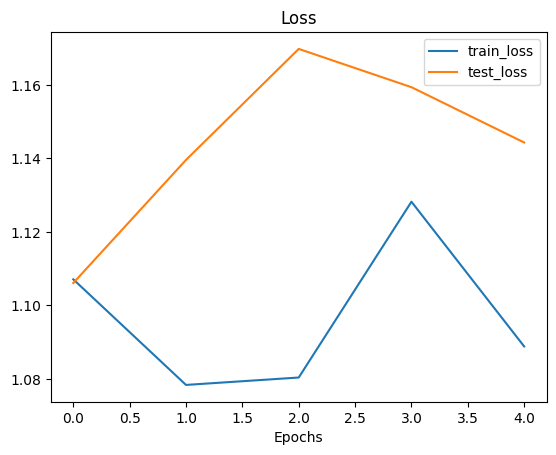

In [ ]:
def plot_loss(results):
  loss = results['train_loss']
  test_loss = results['test_loss']
  epochs = range(len(results['train_loss']))
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss(res)

underfitting, not good

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1070 | test_loss: 1.1383
Epoch: 2 | train_loss: 1.0827 | test_loss: 1.1681
Epoch: 3 | train_loss: 1.1221 | test_loss: 1.1740
Epoch: 4 | train_loss: 1.0955 | test_loss: 1.1427
Epoch: 5 | train_loss: 1.0946 | test_loss: 1.1419


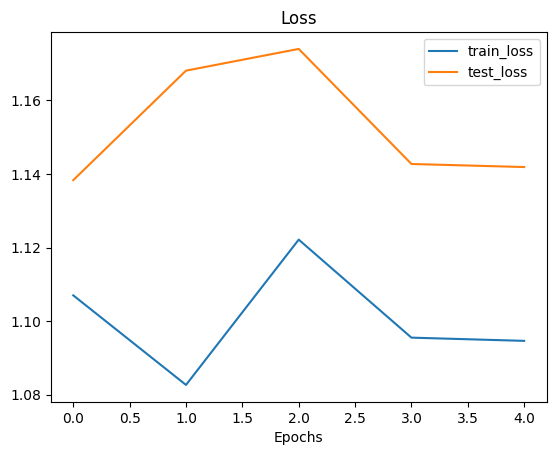

In [ ]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_dataloader_augmented = DataLoader(train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

torch.manual_seed(42)
model1 = TinyVGG(3, 10, len(train_data_augmented.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.001)
model1_results = train(model=model1, train_dataloader=train_dataloader_augmented, test_dataloader=test_dataloader_simple, optimizer=optimizer, loss_fn=loss_fn)

plot_loss(model1_results)